# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES
Edison Giraldo<br>
Joel Orellana<br>
Lyn Mantilla<br>
Ruben Aponte

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets/


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets/

In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [4]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [5]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [6]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [7]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

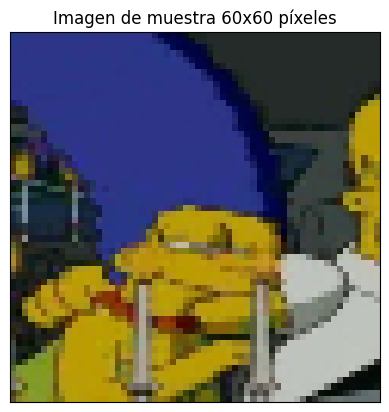

In [8]:
# Mostrar imagen de muestra:
plt.imshow(X_t[7])
plt.xticks([])
plt.yticks([])
plt.title('Imagen de muestra 60x60 píxeles')
plt.show()

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## Desarrollo de la Actividad

### Análisis de los datos:

El *dataset* está compuesto por 18992 imágenes de 60x60 píxeles en RGB para el conjunto de entrenamiento. También, hay 890 imágenes de 60x60 píxles en RGB para el conjunto de test.

In [9]:
# Tamaño del dataset:
print('El tamaño de los datos de entrenamiento es:')
print(X.shape)
print('El tamaño de los datos de test es:')
print(X_t.shape)

El tamaño de los datos de entrenamiento es:
(18992, 60, 60, 3)
El tamaño de los datos de test es:
(890, 60, 60, 3)


### Normalización de datos y *Data Augmentation*:
Se normalizan las imágenes del conjunto de entrenamiento y test y de las imágenes de entrenamiento se extraen los datos para validación con una relación de 80/20.

In [10]:
# Normalizado de las imágenes:
X = X / 255.0
X_t = X_t / 255.0

# Dividir el conjunto de entrenamiento en entrenamiento y validación:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Para mejorar la exactitud del modelo, se utiliza *Data Augmentation* para aumentar los datos de entrenamiento con variaciones de las imágenes presentes inicialmente en el conjunto de entrenamiento. Los parámetros de para las nuevas imágenes son:

- Rotación aleatorio de ± 10 grados.
- Desplazamiento horizontal y vertical aleatorio de ±10%.
- Cizallamiento de la imagen de ±10%.
- Zoom de la imagen de ±10%.
- Volteo horizontal de la imagen.

In [11]:
# Crear un generador de imágenes aumentadas:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Aumentar los datos de entrenamiento:
datagen.fit(X_train)
augmented_data = datagen.flow(X_train, y_train, batch_size=32)

### Modelo de CNN:
Se configura un modelo con las siguientes características:<br>
- Primera capa convolucional 2D, con 32 filtros para extraer características de la imagen, kernel de 3x3 cómo matriz de convolución, función de activación ReLU y forma y tamaño de las imagenes de entrada, en este caso imagenes de 60x60 píxeles RGB.
- Capa oculta MaxPool2D de 2x2 para reducir el tamaño de las características extraídas por la capa de convolución anterior a la mitad, conservando las características más prominentes.
- Capa oculta convolucional 2D, con 64 filtros para extraer características de la imagen, kernel de 3x3 cómo matriz de convolución, función de activación ReLU y forma y tamaño de las imagenes de entrada de la capa anterior.
- Capa oculta MaxPool2D de 2x2 para reducir el tamaño de las características extraídas por la capa de convolución anterior a la mitad, conservando las características más prominentes.
- Capa oculta Flatten para aplanar las características en un vector unidimensional.
- Capa oculta densa de 128 neuronas con función de activación ReLU.
- Capa de salida con 18 neuronas con función de activación SoftMax.

El modelo se compila con optimizador *Adam*, función de pérdida "*sparse-categorical-crossentropy*" y métrica de exactitud.

In [12]:
# Creación del modelo de CNN:
model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(18, activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 128)               1

Se entrena el modelo para 50 epochs.

In [13]:
# Entrenar el modelo con los datos aumentados:
print('Entrenamiento del modelo:\n')
history = model.fit(
    augmented_data,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_val, y_val)
)

# Evaluar el modelo en los datos de prueba:
print('\nEvaluación de datos de prueba:')
test_loss, test_acc = model.evaluate(X_t, y_t, verbose=2)
print('\nAccuracy en datos de prueba:', round(test_acc, 4))

Entrenamiento del modelo:

Epoch 1/50
474/474 [==============================] - 24s 40ms/step - loss: 1.9835 - accuracy: 0.4067 - val_loss: 1.4942 - val_accuracy: 0.5436
Epoch 2/50
474/474 [==============================] - 18s 38ms/step - loss: 1.3750 - accuracy: 0.5916 - val_loss: 1.1727 - val_accuracy: 0.6483
Epoch 3/50
474/474 [==============================] - 18s 39ms/step - loss: 1.1171 - accuracy: 0.6660 - val_loss: 1.1260 - val_accuracy: 0.6615
Epoch 4/50
474/474 [==============================] - 19s 39ms/step - loss: 0.9560 - accuracy: 0.7169 - val_loss: 0.8584 - val_accuracy: 0.7449
Epoch 5/50
474/474 [==============================] - 18s 37ms/step - loss: 0.8438 - accuracy: 0.7464 - val_loss: 0.9148 - val_accuracy: 0.7336
Epoch 6/50
474/474 [==============================] - 18s 38ms/step - loss: 0.7536 - accuracy: 0.7712 - val_loss: 0.7364 - val_accuracy: 0.7886
Epoch 7/50
474/474 [==============================] - 17s 37ms/step - loss: 0.6908 - accuracy: 0.7921 - val_l

### Análisis de resultados:

Se puede observar que la exactitud para los datos de entrenamiento, validación y test despues de 50 epochs son:

| Datos | Accuracy (%) | Loss |
| ----------- | ----------- | ----------- |
| Entrenamiento | 94,65 | 0,1748 |
| Validación | 88,00 | 0,5637 |
| Test | 96,18 | 0,1151 |

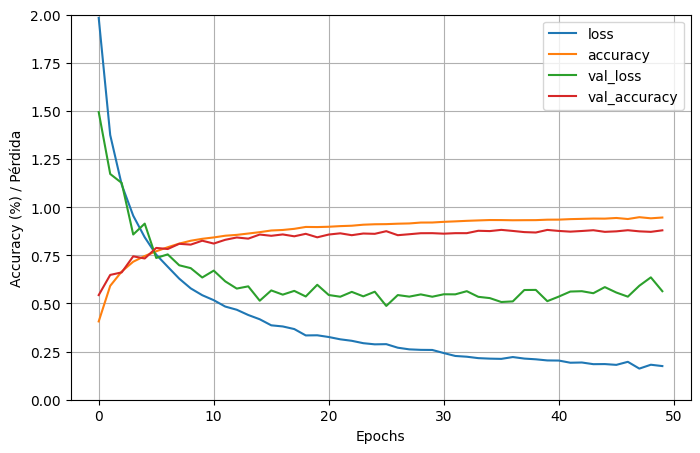

In [14]:
# Creación de la gráfica para mostrar la evolución de las métricas de exactitud y pérdida:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%) / Pérdida")
plt.show()

28/28 [==============================] - 0s 2ms/step

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.96      0.90      0.92        48
           1       0.98      0.98      0.98        50
           2       0.98      0.96      0.97        50
           3       0.96      0.96      0.96        48
           4       0.93      1.00      0.96        50
           5       1.00      0.88      0.93        49
           6       0.98      0.94      0.96        50
           7       0.84      0.98      0.91        50
           8       0.98      0.96      0.97        50
           9       0.98      1.00      0.99        50
          10       1.00      0.96      0.98        50
          11       0.98      0.98      0.98        50
          12       1.00      0.94      0.97        49
          13       0.98      0.98      0.98        50
          14       0.94      0.98      0.96        49
          15       0.94      0.94      0.94        50


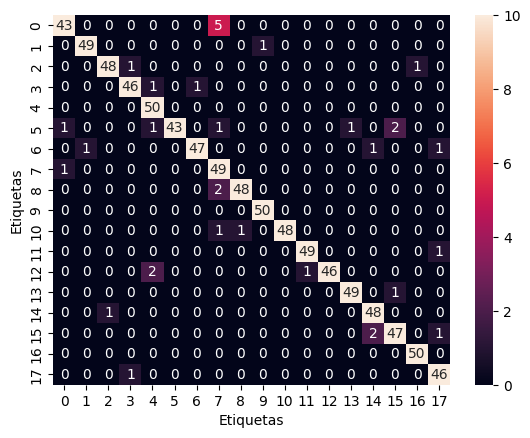

In [15]:
# Creación del reporte de clasificación y matriz de confusión:
y_pred = model.predict(X_t)
y_pred = [i.argmax() for i in y_pred]
y_pred = np.array(y_pred)
print('\nReporte de clasificación:\n')
reporte = classification_report(y_t, y_pred)
print(reporte)
print('\nMatriz de confusión:\n')
sns.heatmap(confusion_matrix(y_t,y_pred), annot=True, vmin=0, vmax=10)
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas')
plt.show()

Se puede ver que los datos de test están balanceados, dado que para cada clase existen alrededor de 50 muestras de cada una. Existen muy pocos falsos positivos y negativos.

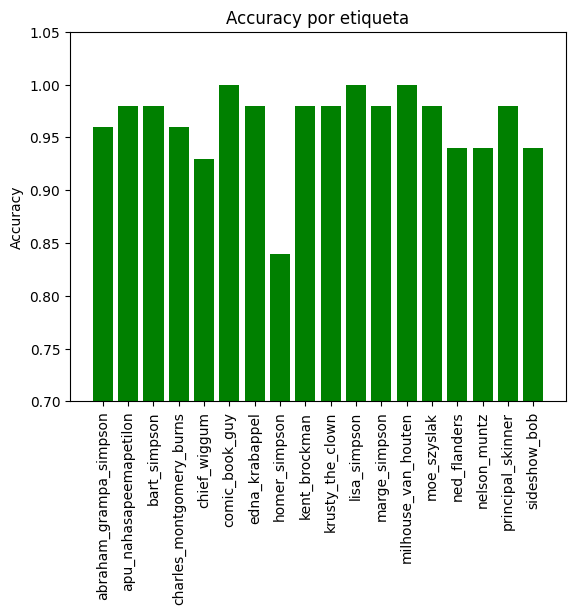

In [16]:
# Mostrar gráfica con la exactitud para cada clase:
lines = reporte.split('\n')
data = [line.split() for line in lines[2:-5]]
columns = ['clase', 'precision', 'recall', 'f1-score', 'soporte']
df = pd.DataFrame(data, columns=columns)
df['precision'] = df['precision'].astype(float)
personajes = pd.DataFrame.from_dict(MAP_CHARACTERS, orient='index', columns=['personajes'])
plt.bar(personajes['personajes'], df['precision'], color='green')
plt.gca().set_ylim(0.7,1.05)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy por etiqueta')
plt.show()

La etiqueta con menor exactitud fue *homer_simpson* con valor de alrededor de 80%.

La siguiente sección genera una muestra para comparar los datos de test con el ajuste del modelo con los datos de test y comparar los resultados.

28/28 [==============================] - 0s 2ms/step

la imagen 726 del conjunto de test es:
1: apu_nahasapeemapetilon

La predicción para la entrada 726 del conjunto de test es:
1: apu_nahasapeemapetilon


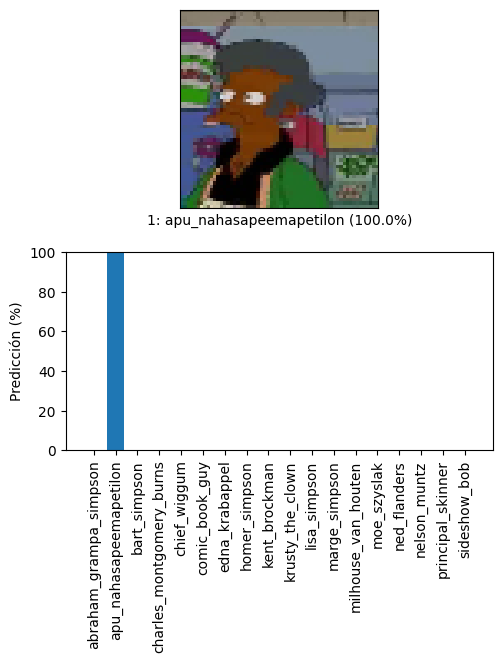

In [17]:
# Realizar predicciones con los datos de test:
clasificacion = model.predict(X_t)
MAP_CHARACTERS_REV = {v: k for k, v in MAP_CHARACTERS.items()}
number = random.randint(0, len(X_t))

nombre_test = list(MAP_CHARACTERS_REV.keys())[list(MAP_CHARACTERS_REV.values()).index(y_t[number])]
nombre_y_pred = list(MAP_CHARACTERS_REV.keys())[list(MAP_CHARACTERS_REV.values()).index(clasificacion[number].argmax())]
coincidencia = clasificacion[number][clasificacion[number].argmax()]

print("\nla imagen {} del conjunto de test es:\n{}: {}".format(number, y_t[number], nombre_test))
print("\nLa predicción para la entrada {} del conjunto de test es:\n{}: {}"
      .format(number, clasificacion[number].argmax(), nombre_y_pred)
     )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
fig.tight_layout()
ax1.imshow(X_t[number], cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("{}: {} ({}%)".format(clasificacion[number].argmax(),
                                     nombre_y_pred,
                                     round(coincidencia*100, 2)))

ax2.bar(personajes['personajes'], clasificacion[number]*100)
ax2.grid(False)
ax2.set_xticklabels(personajes['personajes'], rotation=90)
ax2.set_ylim([0, 100])
ax2.set_ylabel("Predicción (%)");

### Modelo *Fully Connected*:

Se comparan los resultados del modelo CNN con un modelo de RN *Fully Connected*.

Se crea un modelo con:
- Una capa *Flatten* con vector de entrada de imagenes de 60x60 píxles RGB, es deicr, (60, 60, 3) o lo que es lo mismo 10.800 neuronas.
- Dos capas densas de 128 neuronas con funciones de activación ReLU, kernel de inicio *GlorotUniform*, *BatchNormalization* y *Dropout* de 0,5 y 0,3 respectivamente.
- Capa densa de salida con 18 neuronas con función de activación *Softmax*.

Se compila el modelo con optimizador *Adam*, función de pérdida *sparce_categorical_crossentropy* y métricas de exactitud.

In [18]:
# Se crea un modelo Fully Connected:
model_fc = keras.Sequential([
    keras.layers.Flatten(input_shape=(60, 60, 3)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='GlorotUniform'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu', kernel_initializer='GlorotUniform'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),    
    keras.layers.Dense(18, activation='softmax')
])

model_fc.summary()

# Se Compila el modelo con el optimizador RMSprop con un learning rate de 0.0005
model_fc.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10800)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1382528   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                      

Se corre el modelo para 50 *Epochs* y *batch_size*=64.

In [19]:
# Entrenamiento de modelo Fully Connected:
print('Entrenamiento modelo Fully Connected:\n')
history_fc = model_fc.fit(
    augmented_data,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val)
)
print('\n')
test_loss, test_acc = model_fc.evaluate(X_t, y_t, verbose=2)
print("\nLa exactitud en el conjunto de prueba es: {}%".format(round(test_acc*100, 1)))

Entrenamiento modelo Fully Connected:

Epoch 1/50
475/475 [==============================] - 20s 38ms/step - loss: 2.8468 - accuracy: 0.1840 - val_loss: 2.4198 - val_accuracy: 0.2609
Epoch 2/50
475/475 [==============================] - 17s 36ms/step - loss: 2.4814 - accuracy: 0.2407 - val_loss: 2.3642 - val_accuracy: 0.2714
Epoch 3/50
475/475 [==============================] - 18s 39ms/step - loss: 2.4042 - accuracy: 0.2606 - val_loss: 2.1016 - val_accuracy: 0.3604
Epoch 4/50
475/475 [==============================] - 18s 37ms/step - loss: 2.3343 - accuracy: 0.2757 - val_loss: 2.1393 - val_accuracy: 0.3614
Epoch 5/50
475/475 [==============================] - 18s 38ms/step - loss: 2.3082 - accuracy: 0.2859 - val_loss: 2.1291 - val_accuracy: 0.3398
Epoch 6/50
475/475 [==============================] - 18s 37ms/step - loss: 2.2843 - accuracy: 0.2961 - val_loss: 2.0368 - val_accuracy: 0.3833
Epoch 7/50
475/475 [==============================] - 18s 39ms/step - loss: 2.2594 - accuracy: 0.

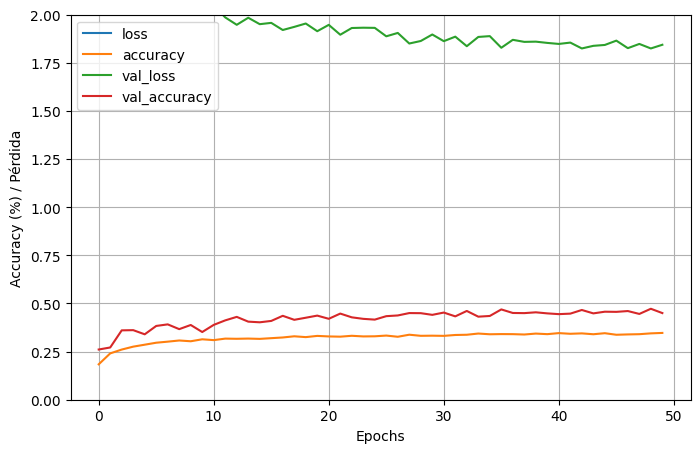

In [20]:
# Creación de la gráfica para mostrar la evolución de las métricas de exactitud y pérdida:
pd.DataFrame(history_fc.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%) / Pérdida")
plt.show()

28/28 [==============================] - 0s 2ms/step

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.28      0.10      0.15        48
           1       0.70      0.66      0.68        50
           2       0.24      0.28      0.26        50
           3       0.64      0.33      0.44        48
           4       0.54      0.60      0.57        50
           5       0.50      0.02      0.04        49
           6       0.60      0.30      0.40        50
           7       0.20      0.58      0.30        50
           8       0.67      0.70      0.69        50
           9       0.46      0.66      0.55        50
          10       0.36      0.38      0.37        50
          11       0.53      0.68      0.60        50
          12       0.50      0.29      0.36        49
          13       0.38      0.46      0.42        50
          14       0.36      0.69      0.48        49
          15       0.00      0.00      0.00        50


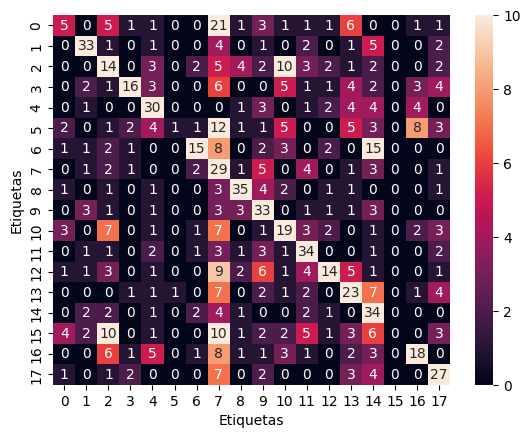

In [21]:
# Creación del reporte de clasificación y matriz de confusión:
y_pred_fc = model_fc.predict(X_t)
y_pred_fc = [i.argmax() for i in y_pred_fc]
y_pred_fc = np.array(y_pred_fc)
print('\nReporte de clasificación:\n')
reporte_fc = classification_report(y_t, y_pred_fc)
print(reporte_fc)
print('\nMatriz de confusión:\n')
sns.heatmap(confusion_matrix(y_t,y_pred_fc), annot=True, vmin=0, vmax=10)
plt.xlabel('Etiquetas')
plt.ylabel('Etiquetas')
plt.show()

Se pueden observar muchos más falsos positivos y negativos en los datos de test, incluso para ciertas etiquetas tiene 0% de exactitud.

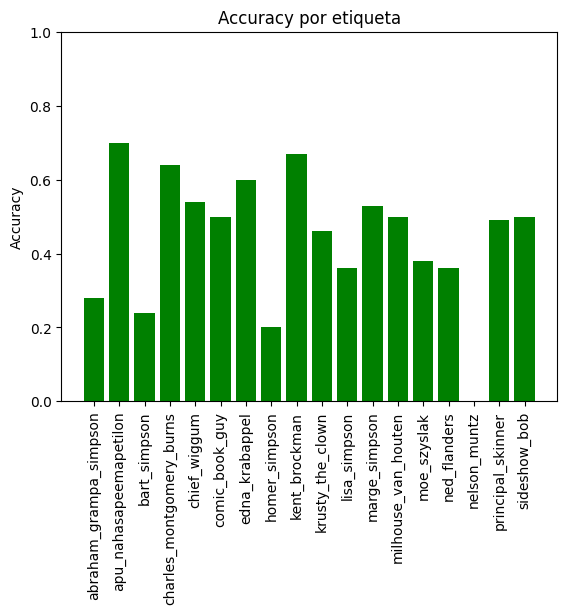

In [22]:
# Mostrar gráfica con la exactitud para cada clase:
lines = reporte_fc.split('\n')
data_fc = [line.split() for line in lines[2:-5]]
columns = ['clase', 'precision', 'recall', 'f1-score', 'soporte']
df_fc = pd.DataFrame(data_fc, columns=columns)
df_fc['precision'] = df_fc['precision'].astype(float)
plt.bar(personajes['personajes'], df_fc['precision'], color='green')
plt.gca().set_ylim(0,1)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy por etiqueta')
plt.show()

28/28 [==============================] - 0s 2ms/step

la imagen 416 del conjunto de test es:
5: comic_book_guy

La predicción para la entrada 416 del conjunto de test es:
7: homer_simpson


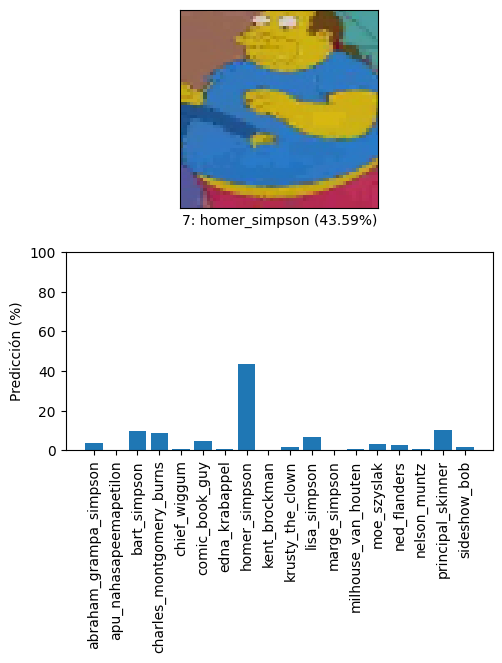

In [23]:
# Realizar predicciones con los datos de test:
clasificacion_fc = model_fc.predict(X_t)
number = random.randint(0, len(X_t))

nombre_test_fc = list(MAP_CHARACTERS_REV.keys())[list(MAP_CHARACTERS_REV.values()).index(y_t[number])]
nombre_y_pred = list(MAP_CHARACTERS_REV.keys())[list(MAP_CHARACTERS_REV.values()).index(clasificacion_fc[number].argmax())]
coincidencia_fc = clasificacion_fc[number][clasificacion_fc[number].argmax()]

print("\nla imagen {} del conjunto de test es:\n{}: {}".format(number, y_t[number], nombre_test_fc))
print("\nLa predicción para la entrada {} del conjunto de test es:\n{}: {}"
      .format(number, clasificacion_fc[number].argmax(), nombre_y_pred)
     )

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
fig.tight_layout()
ax1.imshow(X_t[number], cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("{}: {} ({}%)".format(clasificacion_fc[number].argmax(),
                                     nombre_y_pred,
                                     round(coincidencia_fc*100, 2)))

ax2.bar(personajes['personajes'], clasificacion_fc[number]*100)
ax2.grid(False)
ax2.set_xticklabels(personajes['personajes'], rotation=90)
ax2.set_ylim([0, 100])
ax2.set_ylabel("Predicción (%)");

El modelo es muy pobre para hacer predicciones correctas.

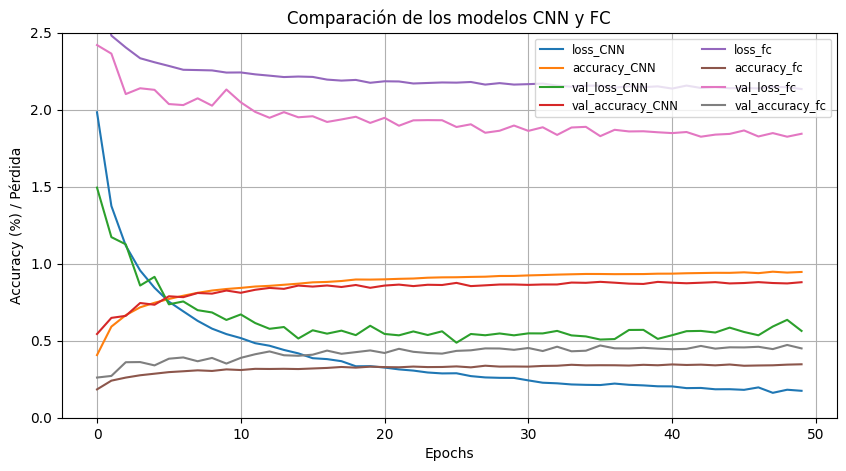

In [25]:
# Mostrar comparativa de modelos:
fig, ax = plt.subplots(figsize=(10,5))
historydf = pd.DataFrame(history.history)
col = ['loss_CNN', 'accuracy_CNN', 'val_loss_CNN',	'val_accuracy_CNN']
historydf.columns = col
historydf_fc = pd.DataFrame(history_fc.history)
col_fc = ['loss_fc', 'accuracy_fc', 'val_loss_fc',	'val_accuracy_fc']
historydf_fc.columns = col_fc
history_full = pd.merge(historydf, historydf_fc, left_index=True, right_index=True)
ax.plot(history_full)
plt.grid(True)
plt.gca().set_ylim(0,2.5)
plt.title('Comparación de los modelos CNN y FC')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%) / Pérdida")
plt.legend(history_full, loc='upper right', fontsize='small', ncol=2)
plt.show()

El modelo *Fully Connected* no logra las métricas que logra el modelo CNN, aún demorandose casi lo mismo en el proceso de entrenamiento (alrededor de 15 min). No es capaz de capturas las características y por ende la pobre exactitud. El resumen general se puede ver en la siguiente tabla:

| Datos | Accuracy CNN (%) | Loss CNN | Accuracy FC (%) | Loss FC |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| Entrenamiento | 94,65 | 0,1748 | 34,70 | 2,1344 |
| Validación | 88,00 | 0,5637 | 45,01 | 1,8439 |
| Test | 96,18 | 0,1151 | 42,70 | 1,9279 |